In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from comet_ml import Experiment
from ipywidgets import interact, IntSlider

from src.data.dataset import split_dataset, tidy_plays_df
from src.data.data_query import StorageEngine
from src.data.plays_model import game_json_to_plays_list
from src.features.features import basic_features, advanced_features, normalize_plays_coords
#from src.models.xgboost import train_xgb

In [2]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [22]:
from sklearn import metrics
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import pickle

In [3]:
df = pd.read_csv("./data/processed/plays_2015-2020.csv", index_col=False)
df, test_df = split_dataset(df)
advanced_df = advanced_features(df)
advanced_df.head()

,seconds_elapsed,period_idx,x_coord,y_coord,x_coord_norm,y_coord_norm,dist_from_net,angle_from_net,Backhand,Deflected,...,SHOT,STOP,TAKEAWAY,previous_x_coord,previous_y_coord,seconds_from_previous,dist_from_previous,rebound,angle_change,speed
5394,51.0,1,-55.0,6.0,55.0,-6.0,34.525353,-10.007980,0,0,...,0,0,0,94.0,-34.0,11.0,154.275727,0,0.000000,14.025066
5395,65.0,1,-79.0,0.0,79.0,-0.0,10.000000,0.000000,0,0,...,0,0,0,-37.0,-28.0,7.0,50.477718,0,0.000000,7.211103
5396,66.0,1,-75.0,-1.0,75.0,1.0,14.035669,4.085617,0,0,...,1,0,0,-79.0,0.0,1.0,4.123106,1,4.085617,4.123106
5397,113.0,1,-55.0,-36.0,55.0,36.0,49.517674,46.636577,0,0,...,0,0,0,-91.0,35.0,18.0,79.605276,0,0.000000,4.422515
5398,157.0,1,-61.0,-1.0,61.0,1.0,28.017851,2.045408,0,0,...,0,0,0,-69.0,-22.0,5.0,22.472205,0,0.000000,4.494441


In [9]:
#df3 = pd.get_dummies(df.shot_type)
df2 = pd.get_dummies(df.period_type)
df['is_goal'] = np.where(df.event_type_id == "GOAL",1,0)
result_df = pd.concat([advanced_df, df2, df[['is_goal']]], axis=1).round(2).fillna(0)
dff = result_df.replace({np.nan: 0, np.inf:0, -np.inf:0})

#### Create train and validation set

In [10]:
X_train, X_test, y_train, y_test = train_test_split(dff.drop(['is_goal','empty_net'],axis=1).fillna(0), dff['is_goal'], test_size=0.30, random_state=42)


### feature selection

In [11]:
model = LogisticRegression()
rfe = RFE(model, n_features_to_select=30, step=1)
fit = rfe.fit(X_train, y_train)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

/opt/anaconda3/envs/DS_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/DS_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Num Features: 30
Selected Features: [ True  True  True  True  True  True  True  True  True  True False  True
  True  True  True False  True  True  True  True False False False  True
  True  True  True False  True  True  True  True  True  True False  True
  True]
Feature Ranking: [1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 7 1 1 1 1 5 8 2 1 1 1 1 6 1 1 1 1 1 1 3 1 1]


/opt/anaconda3/envs/DS_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
feature_select = pd.DataFrame()
feature_select['features'] = X_train.columns
feature_select['RFE_select'] = fit.support_

In [13]:
model = RandomForestClassifier(random_state = 42)
rfe = RFE(model, n_features_to_select=30, step=1)
fit = rfe.fit(X_train, y_train)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

Num Features: 30
Selected Features: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True  True False False False
  True False  True  True  True  True  True  True  True  True False  True
 False]
Feature Ranking: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 1 1 7 5 8 1 4 1 1 1 1 1 1 1 1 2 1 3]


In [24]:
feature_select['RFE_random_forest'] = fit.support_
feature_select['select'] = np.where((feature_select['RFE_select']==True)&(feature_select['RFE_select']==True),1,0)
features = feature_select[feature_select['select']==1]['features'].tolist()

In [16]:
from xverse.transformer import WOE
clf = WOE()
clf.fit(X_train, y_train)

WOE(mono_custom_binning={'BLOCKED_SHOT': array([0., 1.]),
                         'Backhand': array([0., 1.]),
                         'Deflected': array([0., 1.]),
                         'FACEOFF': array([0., 1.]),
                         'GIVEAWAY': array([0., 1.]), 'GOAL': array([0., 1.]),
                         'HIT': array([0., 1.]), 'MISSED_SHOT': array([0., 1.]),
                         'OTHER': array([0., 1.]), 'OVERTIME': array([0., 1.]),
                         'PENALTY': array([0., 1.]),
                         'PERIOD_START': array([0., 1.]),
                         'REGULAR': array...
                                   Interval(-54.0, 54.0, closed='right'): -0.05189122790246956,
                                   Interval(54.0, 99.0, closed='right'): 0.02154891839684451},
              'previous_y_coord': {Interval(-42.001, -13.0, closed='right'): -0.12960622948947284,
                                   Interval(-13.0, 13.0, closed='right'): 0.21013923124825637,

In [20]:
temp = pd.DataFrame(clf.iv_df)
temp[temp['Information_Value']>0.3]

,Variable_Name,Information_Value
24,dist_from_net,0.447066
34,x_coord_norm,0.303175


### Model building

#### MLP classifier

In [ ]:
## Hyperparameter tuning
mlp = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.05],
    
}
clf = RandomizedSearchCV(mlp, parameter_space, n_jobs=-1, cv=5)
clf.fit(X_train[features], y_train)
# Best parameter set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

In [ ]:
y_true, y_pred = y_test , clf.predict(X_test[features])

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

In [ ]:
## MLP
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train[features], y_train)



In [47]:
print(classification_report(y_test, clf.predict(X_test[features])))
print(classification_report(y_train, clf.predict(X_train[features])))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     84601
           1       0.42      0.03      0.06      8731

    accuracy                           0.91     93332
   macro avg       0.67      0.51      0.50     93332
weighted avg       0.86      0.91      0.87     93332

              precision    recall  f1-score   support

           0       0.91      1.00      0.95    197318
           1       0.47      0.03      0.06     20456

    accuracy                           0.91    217774
   macro avg       0.69      0.51      0.51    217774
weighted avg       0.87      0.91      0.87    217774



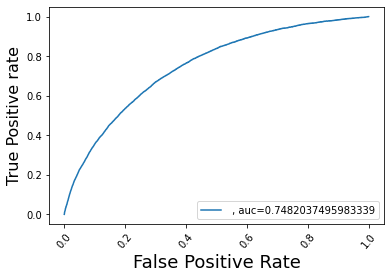

In [48]:
y_pred_proba = clf.predict_proba(X_test[features])[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label=" , auc="+str(auc))
plt.legend(loc=4)
plt.xticks(rotation=50)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive rate', fontsize=16)
plt.show()

### Random forest

In [42]:

randomForest = RandomForestClassifier(random_state = 42, max_depth=6, class_weight = {0: 0.2, 1: 0.8}).fit(X_train[features], y_train)
print(classification_report(y_test, randomForest.predict(X_test[features])))
print(classification_report(y_train, randomForest.predict(X_train[features])))


              precision    recall  f1-score   support

           0       0.92      0.95      0.94     84601
           1       0.31      0.20      0.25      8731

    accuracy                           0.88     93332
   macro avg       0.61      0.58      0.59     93332
weighted avg       0.86      0.88      0.87     93332

              precision    recall  f1-score   support

           0       0.92      0.95      0.94    197318
           1       0.30      0.19      0.24     20456

    accuracy                           0.88    217774
   macro avg       0.61      0.57      0.59    217774
weighted avg       0.86      0.88      0.87    217774



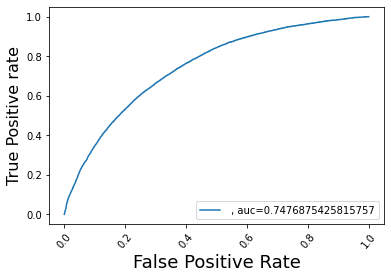

In [44]:

y_pred_proba = randomForest.predict_proba(X_test[features])[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label=" , auc="+str(auc))
plt.legend(loc=4)
plt.xticks(rotation=50)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive rate', fontsize=16)
plt.show()

### Light gbm hyperparameter tuning

In [30]:
##Lightgbm
mdl = LGBMClassifier(objective="binary" ,class_weight={0:0.2,1:0.8,},
                       metric="auc", random_state=42,
                     #n_estimators=500  
                       #min_split_gain = 23
                      )
param1 = {'min_gain_to_split':[0.1, 0.3, 0.5, 0.6],"reg_alpha" :[0.4, 1],
"reg_lambda" : [0.7, 1],}
clf = RandomizedSearchCV(mdl, param1, random_state=42, cv=5)

clf.fit(X_train[features], y_train)

[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGB

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(class_weight={0: 0.2, 1: 0.8},
                                            metric='auc', objective='binary',
                                            random_state=42),
                   param_distributions={'min_gain_to_split': [0.1, 0.3, 0.5,
                                                              0.6],
                                        'reg_alpha': [0.4, 1],
                                        'reg_lambda': [0.7, 1]},
                   random_state=42)

In [31]:
clf.best_estimator_

LGBMClassifier(class_weight={0: 0.2, 1: 0.8}, metric='auc',
               min_gain_to_split=0.1, objective='binary', random_state=42,
               reg_alpha=0.4, reg_lambda=0.7)

In [32]:
# model = LGBMClassifier(class_weight={0: 0.2, 1: 0.8}, metric='auc',
#                min_gain_to_split=0.3, objective='binary',)
# model = LGBMClassifier(class_weight={0: 0.2, 1: 0.8}, metric='auc',
#                min_gain_to_split=0.3, objective='binary', random_state=42,)
#                #reg_alpha=0.4, reg_lambda=1)
model = LGBMClassifier(class_weight={0: 0.2, 1: 0.8}, metric='auc',
               min_gain_to_split=0.1, objective='binary', random_state=42,
               reg_alpha=0.4, reg_lambda=0.7)
model.fit(X_train[features], y_train)
ypred = model.predict(X_test[features])
y_tr_pred = model.predict(X_train[features])



In [36]:
%matplotlib inline

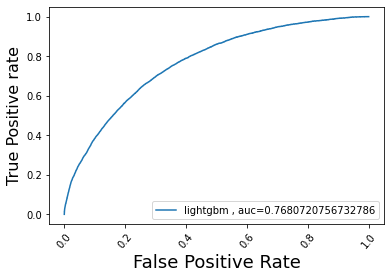

In [37]:
y_pred_proba = model.predict_proba(X_test[features])[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="lightgbm , auc="+str(auc))
plt.legend(loc=4)
plt.xticks(rotation=50)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive rate', fontsize=16)
plt.show()

In [38]:
print('test')
print(classification_report(y_test, model.predict(X_test[features])))
print('train')
print(classification_report(y_train, model.predict(X_train[features])))

test
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     84601
           1       0.30      0.33      0.32      8731

    accuracy                           0.87     93332
   macro avg       0.62      0.63      0.62     93332
weighted avg       0.87      0.87      0.87     93332

train
              precision    recall  f1-score   support

           0       0.93      0.92      0.93    197318
           1       0.32      0.35      0.34     20456

    accuracy                           0.87    217774
   macro avg       0.63      0.64      0.63    217774
weighted avg       0.87      0.87      0.87    217774



/opt/anaconda3/envs/DS_project/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


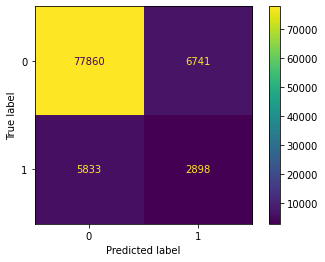

In [39]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test[features], y_test)

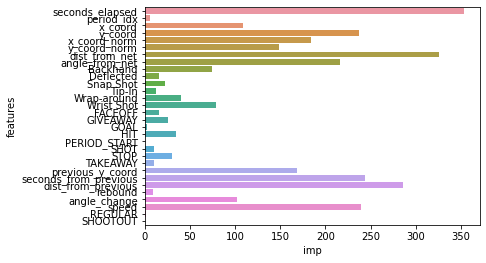

In [40]:
feature_imp = pd.DataFrame()
feature_imp['features'] = features
feature_imp['imp'] = model.feature_importances_

ax = sns.barplot(x="imp", y="features", data=feature_imp)

In [49]:
path = '/Users/henaghonia/Desktop/udem/Sem-1/Data-science/Hockey-all-star-analytics/models/'
filename = path+'lgbm.sav'
pickle.dump(model, open(filename, 'wb'))
filename = path+'randomForest.sav'
pickle.dump(randomForest, open(filename, 'wb'))
filename = path+'MLP.sav'
pickle.dump(clf, open(filename, 'wb'))

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


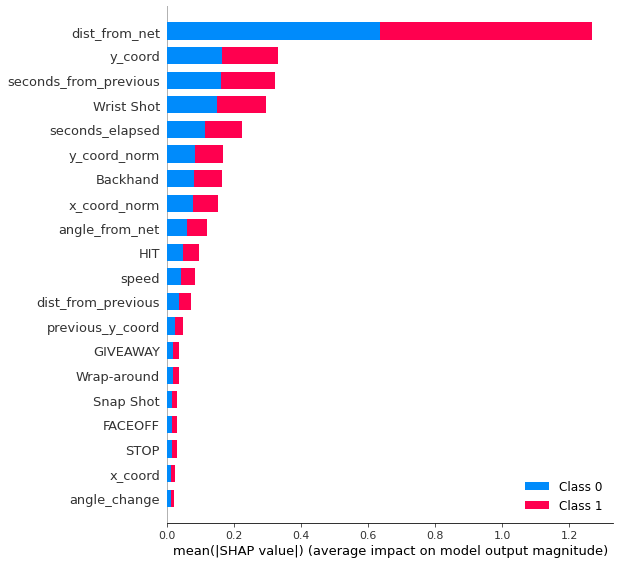

In [41]:
import shap
### Shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test[features])
shap.summary_plot(shap_values, X_test[features])

In [50]:
%%writefile src/models/best_model.py
# import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    project_name="hockey-all-star-analytics",
    workspace="zilto",
)
path = "/Users/henaghonia/Desktop/udem/Sem-1/Data-science/Hockey-all-star-analytics/models/"

experiment.log_model("Best model-LightGBM", path+"lgbm.sav")
experiment.log_model("MLP", path+"MLP.sav")
experiment.log_model("Random forest", path+"randomForest.sav")
experiment.end()

Overwriting src/models/best_model.py


In [70]:
print("features used", features)

features used ['seconds_elapsed', 'period_idx', 'x_coord', 'y_coord', 'x_coord_norm', 'y_coord_norm', 'dist_from_net', 'angle_from_net', 'Backhand', 'Deflected', 'Snap Shot', 'Tip-In', 'Wrap-around', 'Wrist Shot', 'FACEOFF', 'GIVEAWAY', 'GOAL', 'HIT', 'PERIOD_START', 'SHOT', 'STOP', 'TAKEAWAY', 'previous_y_coord', 'seconds_from_previous', 'dist_from_previous', 'rebound', 'angle_change', 'speed', 'REGULAR', 'SHOOTOUT']


### For test data

In [59]:
def feature_data(test_df):
    test_advanced_df = advanced_features(test_df)
    test_df2 = pd.get_dummies(test_df.period_type)
    test_df['is_goal'] = np.where(test_df.event_type_id == "GOAL",1,0)
    result_df = pd.concat([test_advanced_df, test_df2, test_df[['is_goal','game_type']]], axis=1).round(2).fillna(0)
    test_data = result_df.replace({np.nan: 0, np.inf:0, -np.inf:0})
    
    return test_data[(test_data['game_type']=="R")], test_data[(test_data['game_type']=="P")]
Regular_test, play_off_test = feature_data(test_df)

In [63]:
Regualar_pred = pd.DataFrame()
Regualar_pred['pred_proba'] = model.predict_proba(Regular_test[features])[::,1]
Regualar_pred['Prediction'] = model.predict(Regular_test[features])
Regualar_pred['actual'] = np.array(Regular_test['is_goal'])

In [64]:
playoff_pred = pd.DataFrame()
playoff_pred['pred_proba'] = model.predict_proba(play_off_test[features])[::,1]
playoff_pred['Prediction'] = model.predict(play_off_test[features])
playoff_pred['actual'] = np.array(play_off_test['is_goal'])

In [68]:
playoff_pred.to_csv('data/processed/play_off_prediction.csv', index=False)
Regualar_pred.to_csv('data/processed/Regualar_prediction.csv', index=False)

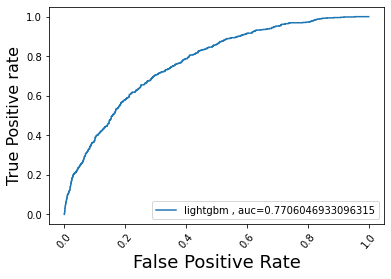

In [66]:
y_pred_proba = playoff_pred['pred_proba']
fpr, tpr, _ = metrics.roc_curve(playoff_pred['actual'],  y_pred_proba)
auc = metrics.roc_auc_score(playoff_pred['actual'], y_pred_proba)
plt.plot(fpr,tpr,label="lightgbm , auc="+str(auc))
plt.legend(loc=4)
plt.xticks(rotation=50)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive rate', fontsize=16)
plt.show()

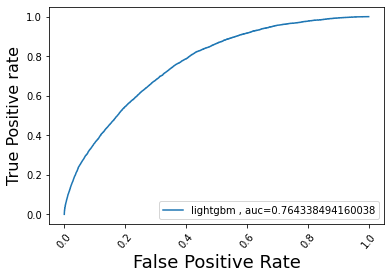

In [67]:
y_pred_proba = Regualar_pred['pred_proba']
fpr, tpr, _ = metrics.roc_curve(Regualar_pred['actual'],  y_pred_proba)
auc = metrics.roc_auc_score(Regualar_pred['actual'], y_pred_proba)
plt.plot(fpr,tpr,label="lightgbm , auc="+str(auc))
plt.legend(loc=4)
plt.xticks(rotation=50)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive rate', fontsize=16)
plt.show()